<h1> Imports and Set-Up

In [1]:
!pip3 install higher
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.autograd import Variable
import random
from higher import innerloop_ctx
import warnings

#The code includes extensive warnings when run so have used this to ignore them
warnings.filterwarnings("ignore")

#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')


domain_type = "multidim_sine"

Available device: cpu


<h1> Data Loading and Generation

This Sine function generator is based on the repostory: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

In [2]:
class SineWaveTask_multi:
    def __init__(self,dimensions=20):
        self.dimensions = dimensions
        self.a = []
        self.b = []
        for dim in range(self.dimensions):
          self.a.append(np.random.uniform(0.1, 5.0))
          self.b.append(np.random.uniform(0, 2*np.pi))
        self.train_x = None
        
    def f(self, x,a,b):
        return a * np.sin(x + b)
        
    def training_set(self, size=10, force_new=False):
        if self.train_x is None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x

        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)

        y = self.f(x,self.a[0],self.b[0])[:,None]

        for dim in range(self.dimensions-1):
          y = np.concatenate((y,self.f(x,self.a[dim+1],self.b[dim+1])[:,None]),axis=-1)

        return torch.Tensor(x[:,None]), torch.Tensor(y)
    
    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x,self.a[0],self.b[0])[:,None]

        for dim in range(self.dimensions-1):
          y = np.concatenate((y,self.f(x,self.a[dim+1],self.b[dim+1])[:,None]),axis=-1)

        return torch.Tensor(x[:,None]), torch.Tensor(y)
    

TRAIN_SIZE = 20000
TEST_SIZE = 1000
SINE_TRAIN = [SineWaveTask_multi() for _ in range(TRAIN_SIZE)]
SINE_TEST = [SineWaveTask_multi() for _ in range(TEST_SIZE)]

In [3]:
x, y_true = SINE_TRAIN[0].training_set()

In [4]:
y_true.shape

torch.Size([10, 20])

<h1> Neural Network Model

In [5]:
# Define network
class Neural_Network_multi(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=20):
        super(Neural_Network_multi, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y


<h1> Helper functions

In [6]:
# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network_multi()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model

def get_samples_in_good_format(wave, num_samples=10, force_new=False):
  #This function is used to sample data from a wave
  x, y_true = wave.training_set(size=num_samples, force_new=force_new)
  # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
  # Note that we convert everything torch tensors
  x = torch.tensor(x)
  y_true = torch.tensor(y_true)
  return x.to(device),y_true.to(device)

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, num_samples=10, force_new=False, item = False):
    # Get data
    x, label = get_samples_in_good_format(wave,num_samples=num_samples, force_new=force_new)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    if item == True: #Depending on whether we need to return the loss value for storing or for backprop
      loss = criterion(prediction,label).item()
    else:
      loss = criterion(prediction,label)
    return loss

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

# for MAML -- see MAML cell for additional citations around structure inspiration
def task_specific_train_and_eval(model, T_i, inner_loop_optimizer, N=1):
    #Description of the loop formulation from https://higher.readthedocs.io/en/latest/toplevel.html
    with innerloop_ctx(model, inner_loop_optimizer, copy_initial_weights = False) as (fmodel,diffopt):
        #get our input data and our label
        x, label = get_samples_in_good_format(T_i,num_samples=num_samples, force_new= True)
        per_step_loss = []
        for _ in range(N):
            #Get the task specific loss for our model
            task_specifc_loss = criterion(fmodel(x), label)

            #Step through the inner gradient
            diffopt.step(task_specifc_loss)
            
            per_step_loss.append(task_specifc_loss.item())
            
        held_out_task_specific_loss = evaluation(fmodel, T_i, num_samples=num_samples, force_new=True)
        
        return held_out_task_specific_loss, per_step_loss, fmodel

<h1> Reptile

In [7]:
#Define important variables
epochs = int(1e5) # number of epochs 
lr_meta=0.001 # Learning rate for meta model (outer loop)
printing_step=1000 # how many epochs should we wait to print the loss
lr_k=0.01 # Internal learning rate
k=5 # Number of internal updates for each task

# Initializations
initialization_to_store_meta_losses()
model = Neural_Network_multi()
metaoptimizer = torch.optim.Adam(model.parameters(), lr=lr_meta)

In [8]:
# Training loop
for epoch in range(epochs):
        
    # Sample a sine wave (Task from training data)
    wave = random.sample(SINE_TRAIN, 1)

    # Update model predefined number of times based on k
    new_model = training(model, wave[0], lr_k, k)

    # Evalaute the loss for the training data
    train_set_evaluation(new_model,wave[0],store_train_loss_meta)     
    
    #Meta-update --> Get gradient for meta loop and update
    metaupdate(model,new_model,metaoptimizer)
    
    # Evalaute the loss for the test data
    # Note that we need to sample the wave from the test data
    wave = random.sample(SINE_TEST, 1)
    test_set_validation(model,new_model,wave[0],lr_k,k,store_test_loss_meta)

    # Print losses every 'printing_step' epochs
    print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

<h1> Few Shot learning with new meta-model

The model performs good few shot learning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0.5, 0, 'k shots')

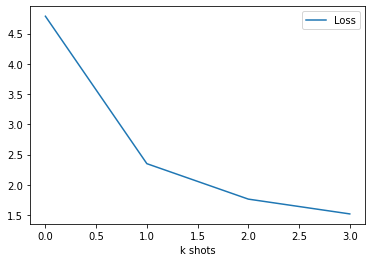

In [9]:
wave = SineWaveTask_multi(); 
k_shot_updates = 4
initialization_to_store_meta_losses()
for shots in range(k_shot_updates):
    new_model = training(model, wave, lr_k, shots)
    train_set_evaluation(new_model,wave,store_train_loss_meta) 

plt.plot(store_train_loss_meta,label = 'Loss')
plt.legend()
plt.xlabel('k shots')

## Second-Order MAML 

In [9]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''


#Instantiate the model network
model = Neural_Network_multi()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

T = 25 # num tasks
N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
num_samples = 10 # number of samples to draw from the task
lr_task_specific = 0.01 # task specific learning rate
lr_meta = 0.001 # meta-update learning rate
num_epochs = 10000#70001 #Number of iterations for outer loop
printing_step = 5000 # show log of loss every x epochs

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = [SineWaveTask_multi() for _ in range(T)]
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        held_out_task_specific_loss, _, _ = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, N)
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = SineWaveTask_multi() # our own addition -- can vary
    val_loss, _, _ = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, N)
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), f"{domain_type}_maml_model.pt")

Iter =  0  Current Loss 4.402935028076172  Val Loss:  4.536915302276611
Iter =  5000  Current Loss 3.3994732285899847  Val Loss:  3.38983383728871


<h1> Few Shot learning with new meta-model (MAML)

(0.0, 10.0)

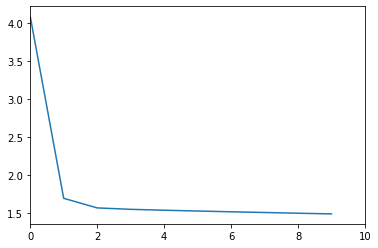

In [11]:
# run k-shot to check how rapidly we are able to adapt to unseen tasks
# starting w/ a single unseen task

test_wave = SineWaveTask_multi()
num_k_shots = 10

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _ = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, num_k_shots)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

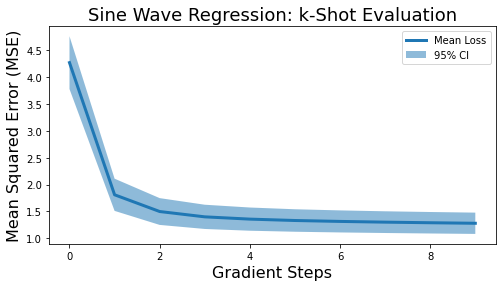

In [17]:
all_losses = []
num_eval = 100 
num_k_shots = 10

for test_eval in range(num_eval): 
    test_wave = SineWaveTask_multi()

    # use model returned from earlier optimization
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
    held_out_task_specific_loss, metaTrainLosses, _ = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, num_k_shots)

    all_losses.append(np.array(metaTrainLosses))

all_losses = np.array(all_losses)
np.save(f"maml_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
ax.fill_between(x, (y-ci), (y+ci), alpha=.5,label=f"95% CI")
ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("sine_wave_multidim_reg_kshot.png")


In [7]:
## Second-Order MAML 

In [ ]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''


#Instantiate the model network
model = Neural_Network_multi()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

T = 25 # num tasks
N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
num_samples = 10 # number of samples to draw from the task
lr_task_specific = 0.01 # task specific learning rate
lr_meta = 0.001 # meta-update learning rate
num_epochs = 10000#70001 #Number of iterations for outer loop
printing_step = 5000 # show log of loss every x epochs

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
    waves = [SineWaveTask_multi() for _ in range(T)]
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        held_out_task_specific_loss, _, _ = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, N)
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
    val_wave = SineWaveTask_multi() # our own addition -- can vary
    val_loss, _, _ = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, N)
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), f"{domain_type}_maml_model.pt")